In [18]:
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import os

from main import *
from model import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

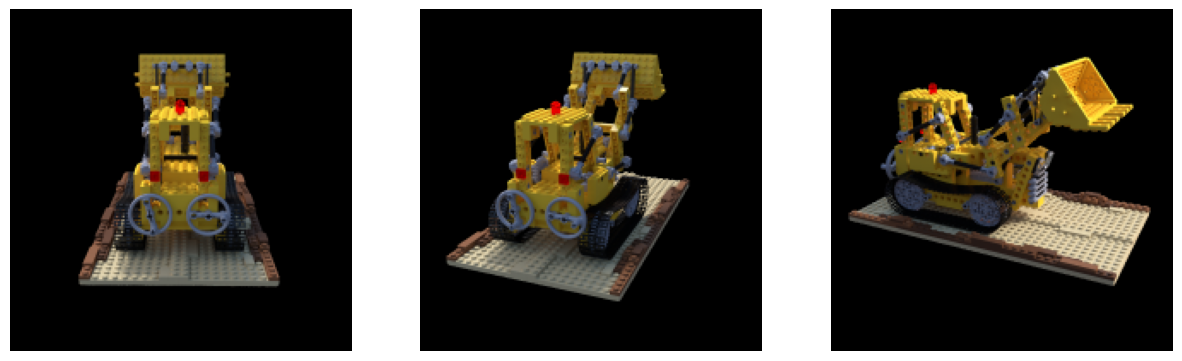

In [3]:
# show 2-3 random images
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].imshow(images_train[i])
    ax[i].axis('off')

In [4]:
batch_size = 10_000
train_dataset = RayDataset(images_train, c2ws_train, focal)
val_dataset = RayDataset(images_val, c2ws_val, focal)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model = Net3d(device)
print(model)

63 27
Net3d(
  (pe_x): PositionalEncoding()
  (pe_rd): PositionalEncoding()
  (mlp1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (mlp2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (density_head): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): ReLU()
  )
  (pre_mix_head): Linear(in_features=256, out_features=256, bias=True)
  (color_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=

In [12]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
loss_list = []
PSNR_list = []

val_loss_list = []
val_PSNR_list = []

def train(model, loss_fn, optimizer):
    
    for i in range(len(train_dataset) // batch_size):
        rays_o, rays_d, rgb_gt = train_dataset.sample_rays(batch_size)
        x = train_dataset.sample_along_rays(rays_o, rays_d) # N x n_samples x 3
        
        optimizer.zero_grad()
        rgb_pred = model(x, rays_d)

        loss = loss_fn(rgb_pred, rgb_gt.to(device))
        loss_list.append(loss.item())
        PSNR_list.append(PSNR(loss).item())

        loss.backward()
        optimizer.step()

        # do validation inference
        if (i + 1) % 25 == 0:
            model.eval()
            with torch.no_grad():
                rays_o, rays_d, rgb_gt = val_dataset.sample_rays(batch_size)
                x = val_dataset.sample_along_rays(rays_o, rays_d)
                rgb_pred = model(x, rays_d)

                val_loss = loss_fn(rgb_pred, rgb_gt.to(device))
                val_loss_list.append(val_loss.item())
                val_PSNR_list.append(PSNR(val_loss).item())

                print(f'Batch {i}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}, Val Loss: {val_loss.item()}, Val PSNR: {PSNR(val_loss).item()}')
            model.train()

        if i % 10 == 0:
            print(f'Batch {i}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}')

In [14]:
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(model, loss_fn, optimizer)

Epoch 1
-------------------------------
Batch 0, Loss: 0.022016337141394615, PSNR: 16.57254981994629
Batch 10, Loss: 0.028436198830604553, PSNR: 15.461283683776855
Batch 20, Loss: 0.022467773407697678, PSNR: 16.484399795532227
Batch 24, Loss: 0.022071069106459618, PSNR: 16.561767578125, Val Loss: 0.023641666397452354, Val PSNR: 16.263219833374023
Batch 30, Loss: 0.024134231731295586, PSNR: 16.17366600036621
Batch 40, Loss: 0.021069582551717758, PSNR: 16.76344108581543
Batch 49, Loss: 0.021020522341132164, PSNR: 16.7735652923584, Val Loss: 0.020752567797899246, Val PSNR: 16.829282760620117
Batch 50, Loss: 0.020967984572052956, PSNR: 16.784433364868164
Batch 60, Loss: 0.020268017426133156, PSNR: 16.931888580322266
Batch 70, Loss: 0.018980884924530983, PSNR: 17.216835021972656
Batch 74, Loss: 0.019361205399036407, PSNR: 17.13067626953125, Val Loss: 0.019471513107419014, Val PSNR: 17.106002807617188
Batch 80, Loss: 0.018500646576285362, PSNR: 17.3281307220459
Batch 90, Loss: 0.018260631710

Text(0.5, 1.0, 'Val PSNR')

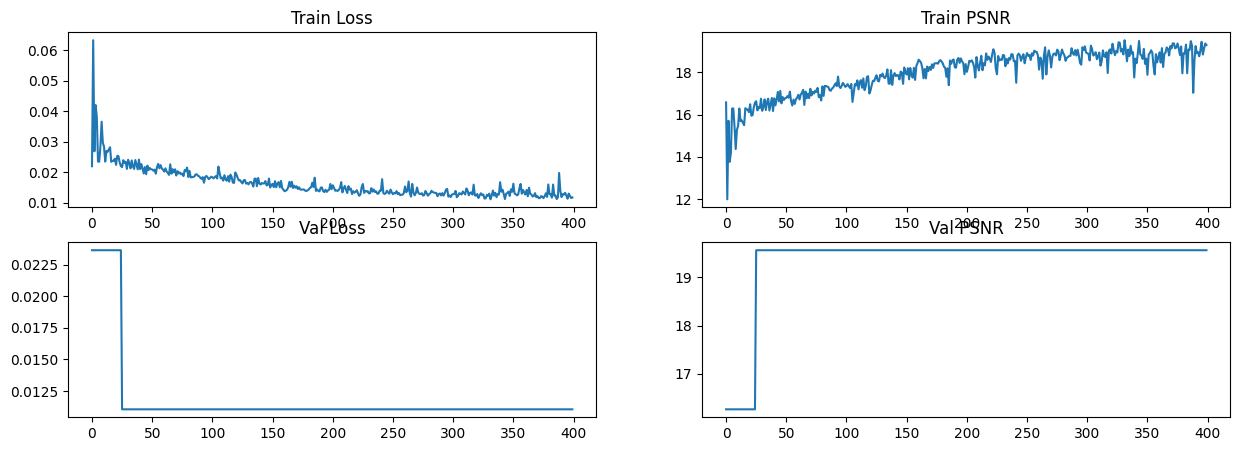

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].plot(loss_list)
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(PSNR_list)
ax[0, 1].set_title('Train PSNR')

ax[1, 0].plot(val_loss_list)
ax[1, 0].set_title('Val Loss')

ax[1, 1].plot(val_PSNR_list)
ax[1, 1].set_title('Val PSNR')

In [45]:
K = train_dataset.K.to('cpu')
display(K.device)
c2w_curr = torch.from_numpy(c2ws_test[0]).to(torch.float32).to(device)
c2w_curr = c2w_curr.unsqueeze(0).expand(40000, -1, -1)
display(model.device)
get_scene_image(model, c2w_curr, K, device).shape

device(type='cuda', index=0)

device(type='cuda')

cuda:0
c2w cuda:0
torch.Size([40000, 4, 4]) torch.Size([40000, 4, 1])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!